In [110]:
%load_ext autoreload
%autoreload 2

import json
from math import pi, log, log2, sqrt
from pathlib import Path
import scipy.stats
import torch
from torch import tensor, Tensor

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import weight_formats.quantisation as Q
import data_utils as D
import plot_utils

plot_utils.OVERLEAF = None
plot_utils.configure()
Path("blog").mkdir(exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


### colours

In [3]:
display([matplotlib.colors.to_hex(color) for color in sns.color_palette()])

['#1b9e77',
 '#d95f02',
 '#7570b3',
 '#e7298a',
 '#66a61e',
 '#e6ab02',
 '#a6761d',
 '#666666']

### `quantile.svg`

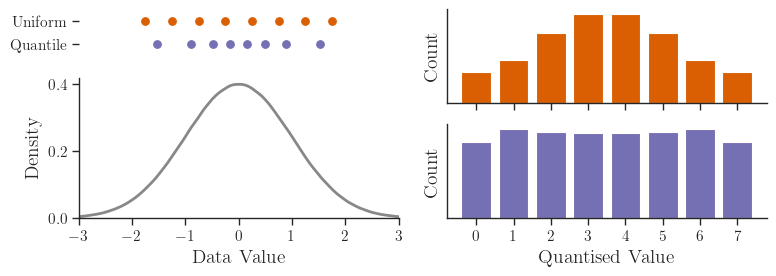

In [ ]:
data = torch.randn(2**22)
c0, c1, c2, *_ = sns.color_palette()

fig = plt.figure(figsize=(8, 3))
gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig)
gs_left = gs[:, 0].subgridspec(2, 1, height_ratios=[1, 3])
gs_right = gs[:, 1].subgridspec(2, 1)
axc = fig.add_subplot(gs_left[0])
axp = fig.add_subplot(gs_left[1], sharex=axc)
axu = fig.add_subplot(gs_right[0])
axq = fig.add_subplot(gs_right[1], sharex=axu)

sns.kdeplot(data, lw=2, color="#888", ax=axp)
axp.set_xlabel("Data Value")
axp.set_xlim((-3, 3))

n = 8

centroids = centroids = torch.linspace(-1.75, 1.75, n)
counts = torch.bincount(torch.bucketize(data, (centroids[:-1] + centroids[1:])/2), minlength=len(centroids))
axc.scatter(centroids, torch.full_like(centroids, 1), marker="o", s=30, color=c1)
axu.bar(torch.arange(n), counts, color=c1)
axu.tick_params(axis="y", left=False, labelleft=False)
axu.tick_params(axis="x", labelbottom=False)
axu.set_ylabel("Count")

centroids = scipy.stats.norm.ppf(torch.linspace(1/(2*n), 1 - 1/(2*n), n))
centroids = torch.tensor(centroids)
counts = torch.bincount(torch.bucketize(data, (centroids[:-1] + centroids[1:])/2), minlength=len(centroids))
axc.scatter(centroids, torch.full_like(centroids, 0), marker="o", s=30, color=c2)
axq.bar(torch.arange(n), counts, color=c2)
axq.set_xticks(torch.arange(n))
axq.tick_params(axis="y", left=False, labelleft=False)
axq.set_ylabel("Count")
axq.set_xlabel("Quantised Value")

axc.get_xaxis().set_visible(False)
axc.spines["bottom"].set_visible(False)
axc.spines["left"].set_visible(False)
axc.set_yticks([0, 1], ["Quantile", "Uniform"])
axc.set_ylim((-0.5, 1.5))

fig.tight_layout()
fig.savefig("blog/quantile.svg")

### `ppf.svg`

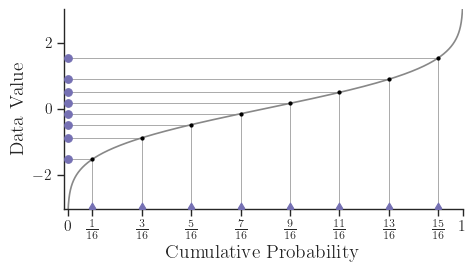

In [222]:
_, ax = plt.subplots(figsize=(5, 3))

color = sns.color_palette()[2]

xs = torch.linspace(0, 1, 6001)
ax.plot(xs, scipy.stats.norm.ppf(xs), color="#888")

n = 8
ps = torch.linspace(1/(2*n), 1 - 1/(2*n), n)
centroids = torch.tensor(scipy.stats.norm.ppf(ps))
ax.scatter(ps, centroids, s=5, color="k", zorder=10)
ax.scatter(torch.zeros_like(centroids), centroids, s=30, color=color, zorder=10)
ax.scatter(ps, torch.full_like(ps, -3), s=30, color=color, marker="d", zorder=10)
for p, c in zip(ps, centroids):
    ax.plot([p, p, -3], [-3, c, c], color="#888", lw=0.5)
ax.set_xlim((-.01, 1))
ax.set_ylim((-3.03, 3))
ax.set_xticks([0] + ps.tolist() + [1])
ax.xaxis.set_major_formatter(plot_utils.format_fraction(20))
ax.set_ylabel("Data Value")
ax.set_xlabel("Cumulative Probability")
ax.figure.tight_layout()
ax.figure.savefig("blog/ppf.svg")

### `crd_iplot_alpha`

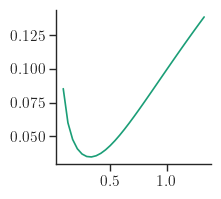

In [6]:
torch.manual_seed(100)
data = torch.randn(2**22)
n = 8
step = 1/(8*3)
alphas = torch.arange(2*step, 4/3 + 1e-6, step).tolist()

log = []
for alpha in alphas:
    if alpha == 0:
        a = 2  # manual fit (2 : n=8, 2.5 : n=16)
        centroids = torch.linspace(-a, a, n)
    else:
        centroids = torch.tensor(scipy.stats.norm.ppf(torch.linspace(0, 1, n+2)[1:-1]) * alpha**-0.5)
    idx = torch.bucketize(data, (centroids[:-1] + centroids[1:])/2)
    density = torch.bincount(idx, minlength=len(centroids)) / len(idx)
    mse = (data - centroids[idx]).pow(2).mean()
    log.append(dict(
        alpha=alpha,
        mse=mse.item(),
        centroids=centroids.tolist(),
        density=density.tolist(),
    ))

Path("blog/iplot_alpha.json").write_text(json.dumps([
    dict(alpha=round(d["alpha"], 4), mse=round(d["mse"], 4), centroids=[round(x, 3) for x in d["centroids"]], density=[round(x, 3) for x in d["density"]])
    for d in log
], separators=(",",":")))

_, ax = plt.subplots(figsize=(2, 2))
ax.plot([x["alpha"] for x in log], [x["mse"] for x in log])

### `crd_quantisers`

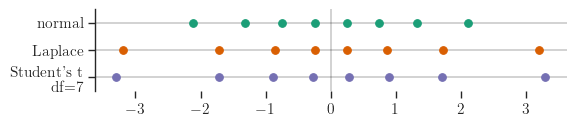

In [49]:
n = 8
p = torch.linspace(0, 1, n + 2)[1:-1]

centroids_normal = scipy.stats.norm.ppf(p, scale=sqrt(3))

centroids_laplace = scipy.stats.laplace.ppf(p, scale=3/sqrt(2))

df = 7
centroids_t = scipy.stats.t.ppf(p, (df-2)/3, scale=sqrt(3))

torch.testing.assert_close(tensor(centroids_normal), tensor(Q.crd_normal(log2(n), "symmetric").values))
torch.testing.assert_close(tensor(centroids_laplace), tensor(Q.crd_laplace(log2(n), "symmetric").values))
torch.testing.assert_close(tensor(centroids_t), tensor(Q.crd_t(log2(n), df, "symmetric").values))

_, ax = plt.subplots(figsize=(6, 1.5))
s = 30
ax.scatter(centroids_normal, torch.full_like(torch.tensor(centroids_normal), 0), s=s)
ax.scatter(centroids_laplace, torch.full_like(torch.tensor(centroids_laplace), -1), s=s)
ax.scatter(centroids_t, torch.full_like(torch.tensor(centroids_t), -2), s=s)
ax.spines["bottom"].set_visible(False)
ax.set_ylim((-2.5, 0.5))
for y in [0, -1, -2]:
    ax.axhline(y, color="k", lw=0.25, zorder=0)
ax.axvline(0, color="k", lw=0.25)
ax.yaxis.set_ticks([0, -1, -2], ["normal", "Laplace", f"Student's t\ndf={df}"])
ax.figure.tight_layout()
ax.figure.savefig("blog/crd_rms.svg")


### `heavy_tails`

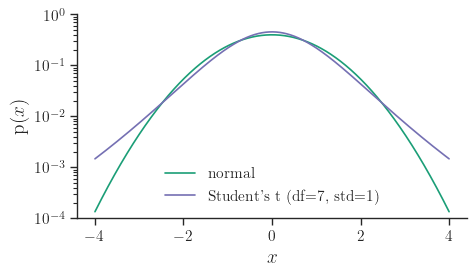

In [78]:
df = 7
_, ax = plt.subplots(figsize=(5, 3))
xs = torch.linspace(-4, 4, 1001)
ax.plot(xs, scipy.stats.norm.pdf(xs), label="normal")
ax.plot(xs, scipy.stats.t.pdf(xs, df=df, scale=sqrt((df-2)/df)),
        label=f"Student's t (df={df}, std=1)", color=sns.color_palette()[2])
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\mathrm{p}(x)$");
ax.set_ylim((10**-4, 1))
ax.figure.tight_layout()
ax.figure.savefig("blog/heavy_tails.svg")

### `block_absmax`

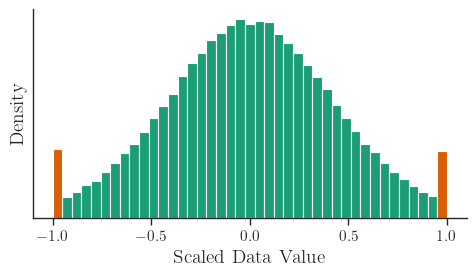

In [107]:
data = torch.randn(2**18)

block_size = 32
data = data.view(-1, block_size)
scale = data.abs().amax(-1)
data /= scale.unsqueeze(-1)
data = data.flatten(-2)

_, ax = plt.subplots(figsize=(5, 3))
ax.hist(data[data.abs() != 1], bins=41)
ax.hist(data[data.abs() == 1], bins=41)
ax.tick_params(axis="y", left=False, labelleft=False)
ax.set_ylabel("Density")
ax.set_xlabel("Scaled Data Value")
ax.set_xticks(torch.linspace(-1, 1, 5))
ax.figure.tight_layout()
ax.figure.savefig("blog/block_absmax.svg")

### `crd_block`

In [ ]:
n, block_size = 8, 64
p = torch.linspace(0, 1, n)

from scipy.stats import norm

scale = sqrt(3 / (2 * log(block_size/pi)))
c0, c1 = norm.cdf([-1, 1], scale=scale)
centroids_normal = norm.ppf(torch.linspace(c0, c1, n), scale=scale)

torch.testing.assert_close(tensor(centroids_normal), tensor(Q.crd_block_normal(log2(n), block_size).values))

from scipy.stats import laplace

scale = 3 / (0.57721566 + log(block_size))
c0, c1 = laplace.cdf([-1, 1], scale=scale)
centroids_laplace = laplace.ppf(torch.linspace(c0, c1, n), scale=scale)

torch.testing.assert_close(tensor(centroids_laplace).float(), tensor(Q.crd_block_laplace(log2(n), block_size).values))

from scipy.stats import t

df = 7
df_ = (df - 2) / 3
scale = ((2 * log(block_size / pi)) ** ((3-df)/(2*df))
            * block_size ** (-1/df)
            * sqrt(3))

c0, c1 = t.cdf([-1, 1], df_, scale=scale)
centroids_t = t.ppf(torch.linspace(c0, c1, n), df_, scale=scale)

torch.testing.assert_close(tensor(centroids_t), tensor(Q.crd_block_t(log2(n), block_size, df).values),
                           atol=1e-6, rtol=0)